#**Import Libraries**



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer, SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix,f1_score
from sklearn.decomposition import PCA
import pickle

import warnings
warnings.filterwarnings('ignore')

#**Phase 1: Become a Data Explorer!**

## **Load the Data**

In [2]:
df = pd.read_csv("/content/diabetes.csv")

In [3]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
df.shape

(768, 9)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


## **Train - Test Split**

In [6]:
x,y = df.drop(['Outcome'], axis = 1), df['Outcome']

In [7]:
x_train , x_test , y_train , y_test = train_test_split(x,y,test_size=0.2,random_state=42)

In [8]:
train_data = x_train.join(y_train)
test_data = x_test.join(y_test)

## **Data Exploration & Visualization**

In [9]:
train_data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000
mean,3.742671,120.855049,69.415309,20.399023,81.438111,31.983388,0.469168,32.907166,0.346906
std,3.313264,32.035057,18.512599,15.433974,116.234835,7.740625,0.336847,11.503437,0.476373
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,100.000000,64.000000,0.000000,0.000000,27.100000,0.241500,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,42.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,139.000000,80.000000,32.000000,129.750000,36.375000,0.613750,40.000000,1.000000
max,17.000000,199.000000,122.000000,63.000000,846.000000,67.100000,2.420000,81.000000,1.000000


array([[<Axes: title={'center': 'Pregnancies'}>,
        <Axes: title={'center': 'Glucose'}>,
        <Axes: title={'center': 'BloodPressure'}>],
       [<Axes: title={'center': 'SkinThickness'}>,
        <Axes: title={'center': 'Insulin'}>,
        <Axes: title={'center': 'BMI'}>],
       [<Axes: title={'center': 'DiabetesPedigreeFunction'}>,
        <Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'Outcome'}>],
       [<Axes: >, <Axes: >, <Axes: >]], dtype=object)

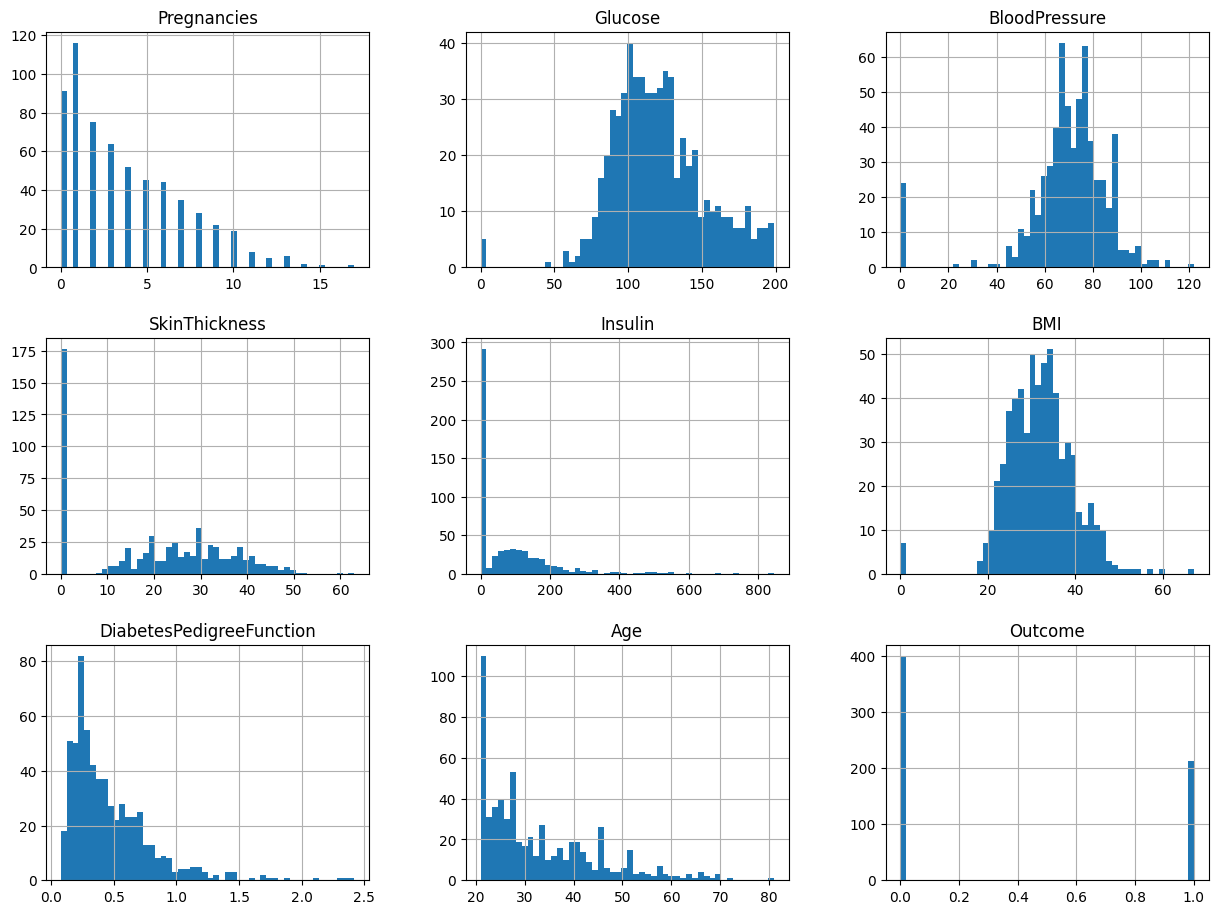

In [10]:
# Histogram
train_data.hist(bins=50, figsize=(15,15), layout=(4, 3))

<Axes: >

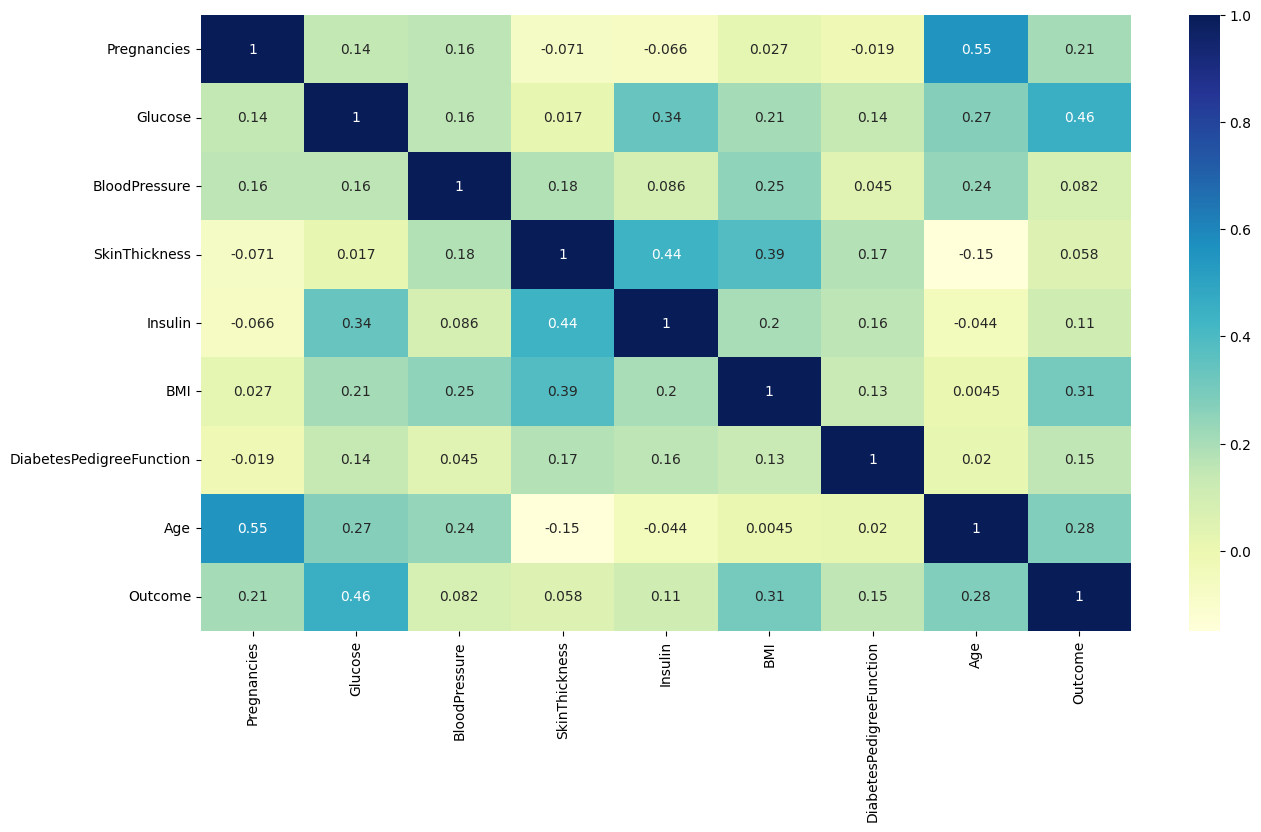

In [11]:
# Correlation Heatmap
plt.figure(figsize=(15, 8))
sns.heatmap(train_data.corr(), annot=True, cmap='YlGnBu')

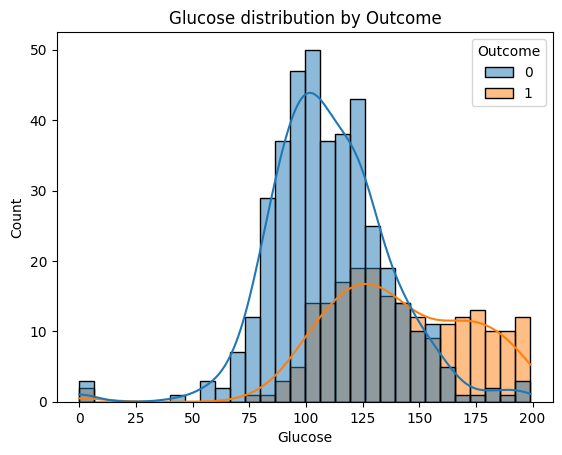

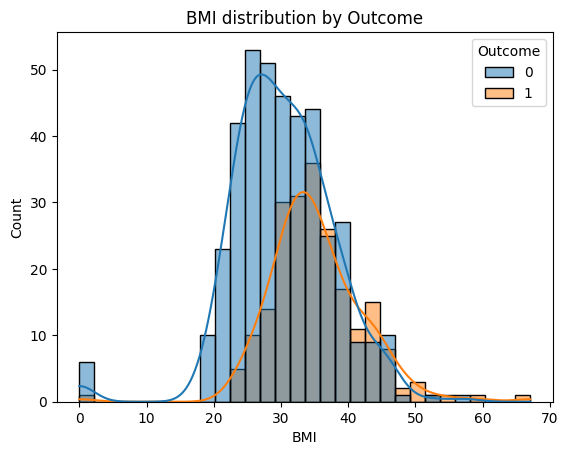

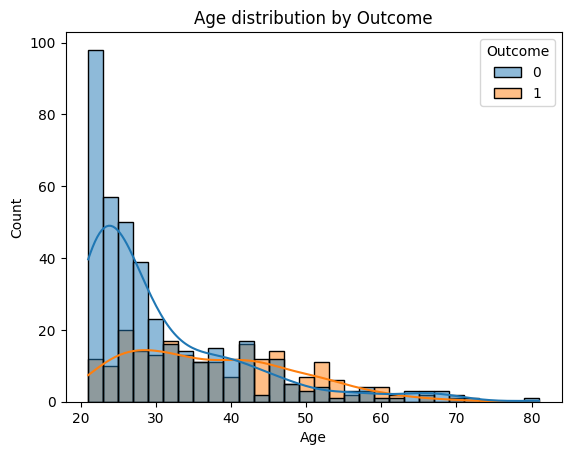

In [12]:
# Columns Distribution by Outcome
for col in ['Glucose','BMI','Age']:
    sns.histplot(data=train_data, x=col, hue='Outcome', kde=True, bins=30)
    plt.title(f"{col} distribution by Outcome")
    plt.show()

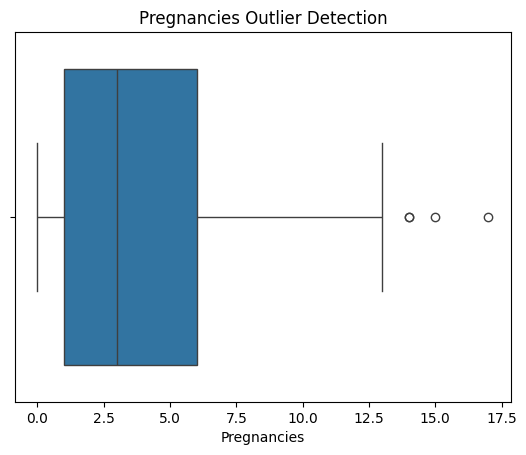

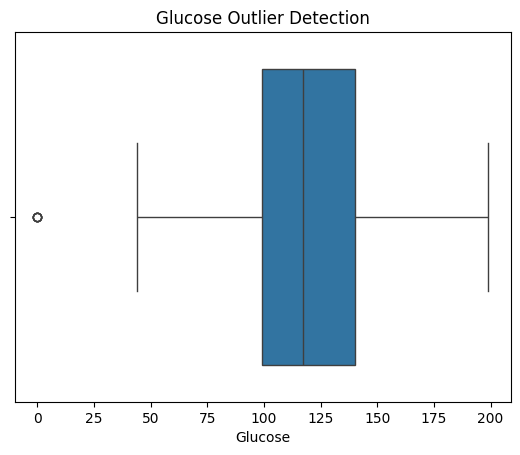

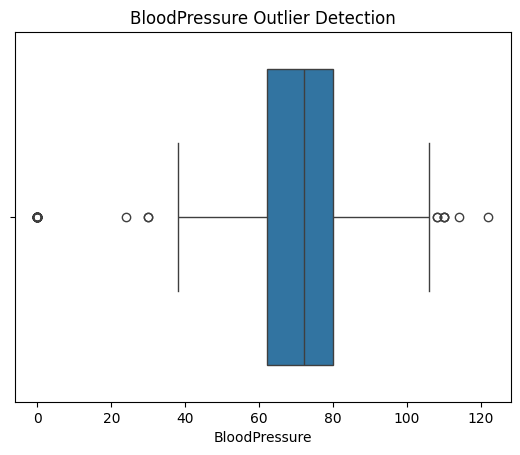

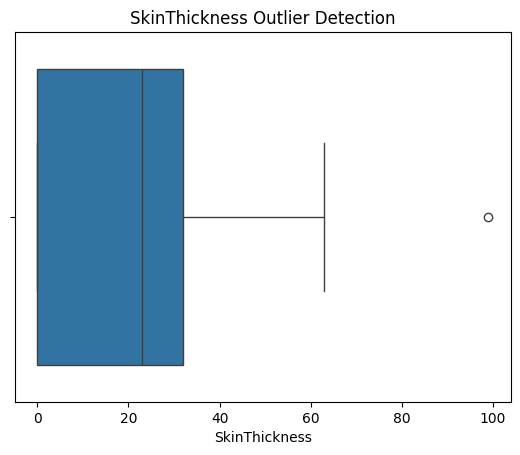

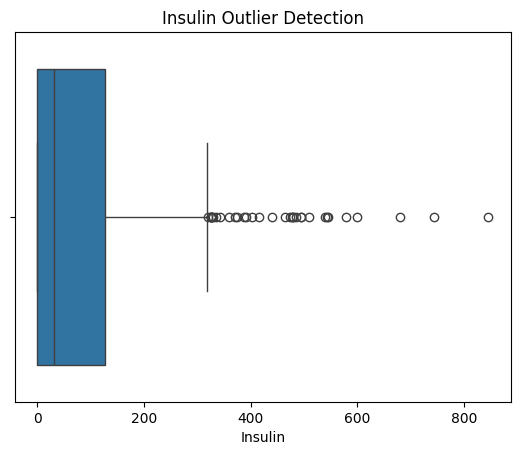

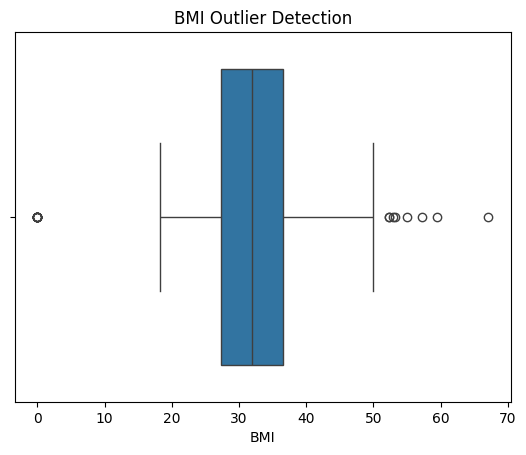

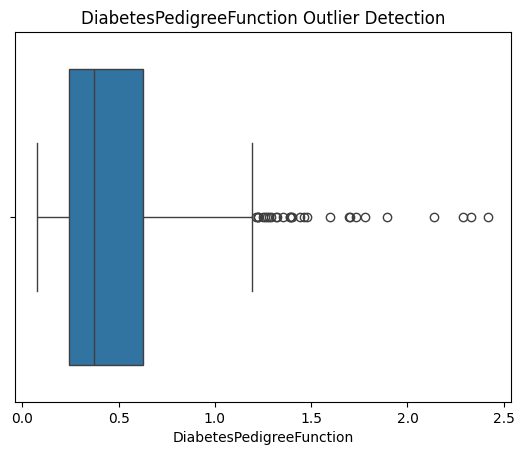

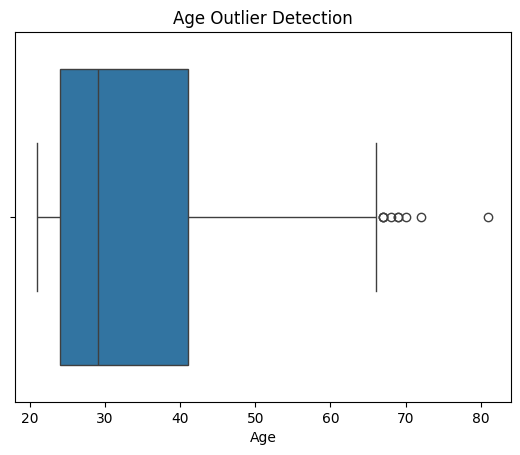

In [13]:
# Outlier Detection
x_columns = train_data.columns[:-1]
for col in x_columns :
    sns.boxplot(x=df[col])
    plt.title(f"{col} Outlier Detection")
    plt.show()

In [14]:
def detect_outliers_all(df):
    outlier_summary = {}
    for col in df.select_dtypes(include=[np.number]).columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR

        outliers = df[(df[col] < lower) | (df[col] > upper)]
        outlier_summary[col] = {
            "lower_bound": lower,
            "upper_bound": upper,
            "num_outliers": outliers.shape[0],
            "percent_outliers": round(outliers.shape[0] / df.shape[0] * 100, 2)
        }
    return pd.DataFrame(outlier_summary).T

outlier_report = detect_outliers_all(train_data[x_columns])
print(outlier_report)

                          lower_bound  upper_bound  num_outliers  \
Pregnancies                 -6.500000    13.500000           4.0   
Glucose                     41.500000   197.500000           7.0   
BloodPressure               40.000000   104.000000          33.0   
SkinThickness              -48.000000    80.000000           0.0   
Insulin                   -194.625000   324.375000          26.0   
BMI                         13.187500    50.287500          13.0   
DiabetesPedigreeFunction    -0.316875     1.172125          26.0   
Age                          0.000000    64.000000          13.0   

                          percent_outliers  
Pregnancies                           0.65  
Glucose                               1.14  
BloodPressure                         5.37  
SkinThickness                         0.00  
Insulin                               4.23  
BMI                                   2.12  
DiabetesPedigreeFunction              4.23  
Age                        

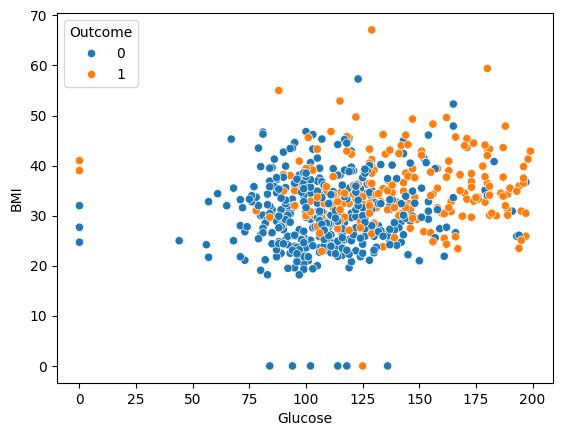

In [15]:
# Glucose vs BMI categorized by Outcome
sns.scatterplot(data=train_data, x='Glucose', y='BMI', hue='Outcome')
plt.show()

In [16]:
# Count patients per age group
age_counts = pd.cut(train_data['Age'], bins=[20,30,40,50,60,70,80], labels=['20s','30s','40s','50s','60s','70s']).value_counts()
print(age_counts.sort_index())

Age
20s    336
30s    127
40s     93
50s     39
60s     17
70s      1
Name: count, dtype: int64


In [17]:
# Calculate diabetes rate per age group
age_risk = df.groupby(pd.cut(train_data['Age'], bins=[20,30,40,50,60,70,80], labels=['20s','30s','40s','50s','60s','70s']))['Outcome'].mean()
print(age_risk)

Age
20s    0.205357
30s    0.464567
40s    0.580645
50s    0.666667
60s    0.294118
70s    0.000000
Name: Outcome, dtype: float64


In [18]:
age_summary = df.groupby(pd.cut(train_data['Age'], bins=[20,30,40,50,60,70,80], labels=['20s','30s','40s','50s','60s','70s'])).agg(total_patients=('Outcome','count'),diabetic_count=('Outcome','sum'),diabetes_rate=('Outcome','mean'))
print(age_summary)


     total_patients  diabetic_count  diabetes_rate
Age                                               
20s             336              69       0.205357
30s             127              59       0.464567
40s              93              54       0.580645
50s              39              26       0.666667
60s              17               5       0.294118
70s               1               0       0.000000


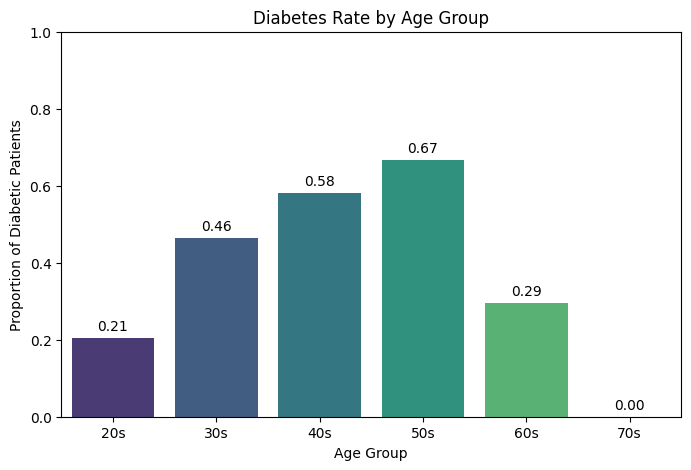

In [19]:
plt.figure(figsize=(8,5))
sns.barplot(x=age_summary.index, y=age_summary['diabetes_rate'], palette="viridis")

plt.title("Diabetes Rate by Age Group")
plt.xlabel("Age Group")
plt.ylabel("Proportion of Diabetic Patients")
plt.ylim(0, 1)

for i, rate in enumerate(age_summary['diabetes_rate']):
    plt.text(i, rate + 0.02, f"{rate:.2f}", ha='center')

plt.show()

# **Phase 2: Prep Your Data for Prime Time**

## **Handle outliers**

In [20]:
# cap columns that are not extremely skewed
cap_columns = ['BloodPressure', 'BMI', 'DiabetesPedigreeFunction']

for col in cap_columns:
    Q1 = train_data[col].quantile(0.25)
    Q3 = train_data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    train_data[col] = np.where(train_data[col] < lower, lower,
                               np.where(train_data[col] > upper, upper, train_data[col]))

    test_data[col] = np.where(test_data[col] < lower, lower,
                              np.where(test_data[col] > upper, upper, test_data[col]))

In [21]:
# log transform columns that are very skewed
train_data['Insulin'] = np.log1p(train_data['Insulin'])
test_data['Insulin'] = np.log1p(test_data['Insulin'])

array([[<Axes: title={'center': 'Pregnancies'}>,
        <Axes: title={'center': 'Glucose'}>,
        <Axes: title={'center': 'BloodPressure'}>],
       [<Axes: title={'center': 'SkinThickness'}>,
        <Axes: title={'center': 'Insulin'}>,
        <Axes: title={'center': 'BMI'}>],
       [<Axes: title={'center': 'DiabetesPedigreeFunction'}>,
        <Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'Outcome'}>],
       [<Axes: >, <Axes: >, <Axes: >]], dtype=object)

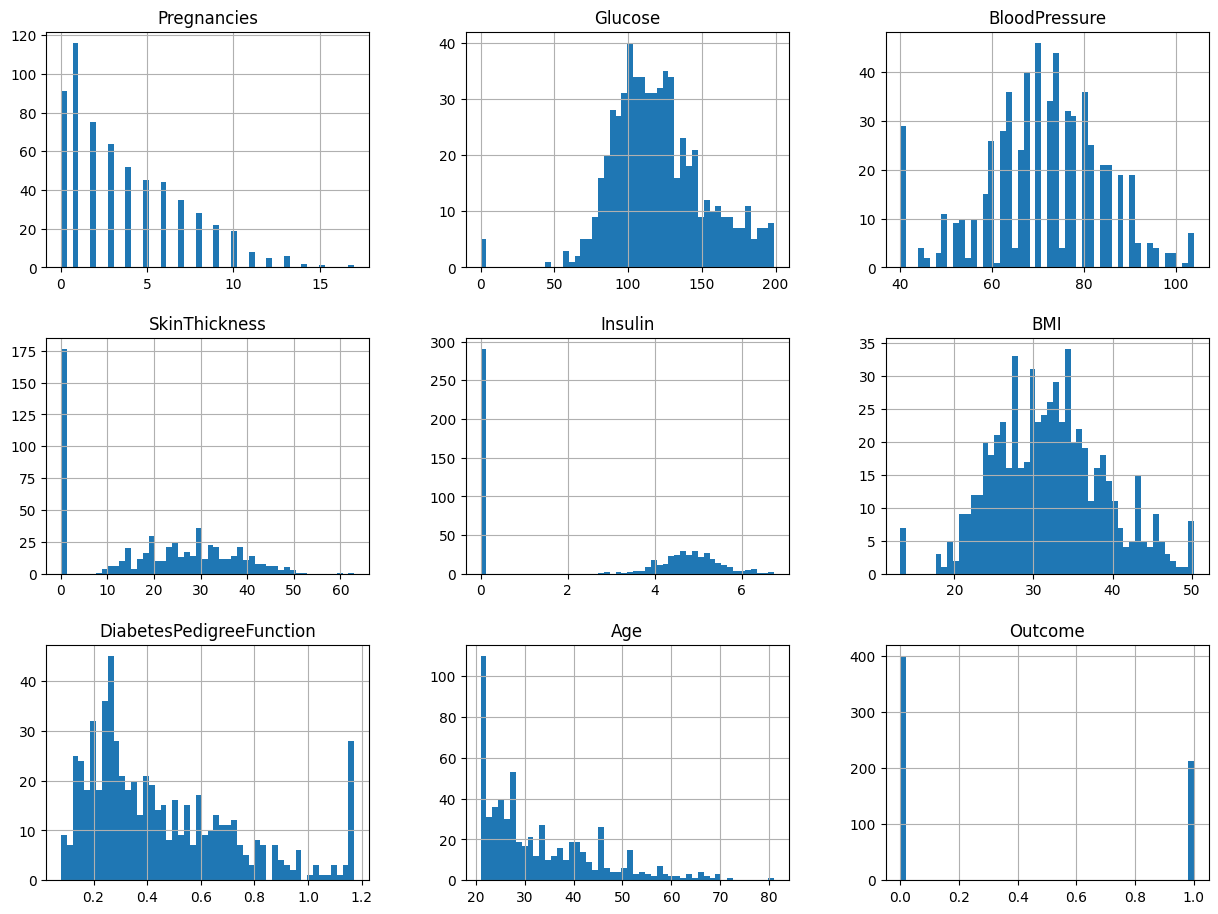

In [22]:
# Histogram after treating outliers
train_data.hist(bins=50, figsize=(15,15), layout=(4, 3))

## **Feature Engineering**

In [23]:
# Age Groups
age_bins = [0, 20, 30, 40, 50, 60, 70, 120]
age_labels = ['<20', '20s','30s','40s','50s','60s','70+']

train_data['AgeGroup'] = pd.cut(train_data['Age'], bins=age_bins, labels=age_labels, include_lowest=True)
test_data['AgeGroup'] = pd.cut(test_data['Age'], bins=age_bins, labels=age_labels, include_lowest=True)

age_mapping = {'<20': 0, '20s': 1, '30s': 2, '40s': 3, '50s': 4, '60s': 5, '70+': 6}

train_data['AgeGroup'] = train_data['AgeGroup'].map(age_mapping).astype(int)
test_data['AgeGroup'] = test_data['AgeGroup'].map(age_mapping).astype(int)


In [24]:
# Pregnancies per Age ratio
train_data['Preg_Age_Ratio'] = train_data['Pregnancies'] / train_data['Age']
test_data['Preg_Age_Ratio'] = test_data['Pregnancies'] / test_data['Age']

In [25]:
# BMI Category
def bmi_category(bmi):
    if bmi < 18.5:
        return 'Underweight'
    elif bmi < 25:
        return 'Normal'
    elif bmi < 30:
        return 'Overweight'
    else:
        return 'Obese'

train_data['BMI_Category'] = train_data['BMI'].apply(bmi_category)
test_data['BMI_Category'] = test_data['BMI'].apply(bmi_category)

train_data = train_data.join(pd.get_dummies(train_data.BMI_Category,dtype=int)).drop('BMI_Category',axis=1)
test_data = test_data.join(pd.get_dummies(test_data.BMI_Category,dtype=int)).drop('BMI_Category',axis=1)

In [26]:
# Glucose × BMI interaction
train_data['Glucose_BMI'] = train_data['Glucose'] * train_data['BMI']
test_data['Glucose_BMI'] = test_data['Glucose'] * test_data['BMI']

In [27]:
train_data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,AgeGroup,Preg_Age_Ratio,Normal,Obese,Overweight,Underweight,Glucose_BMI
60,2,84,40.0,0,0.000000,13.1875,0.304000,21,0,1,0.095238,0,0,0,1,1107.75
618,9,112,82.0,24,0.000000,28.2000,1.172125,50,1,3,0.180000,0,0,1,0,3158.40
346,1,139,46.0,19,4.430817,28.7000,0.654000,22,0,1,0.045455,0,0,1,0,3989.30
294,0,161,50.0,0,0.000000,21.9000,0.254000,65,0,5,0.000000,1,0,0,0,3525.90
231,6,134,80.0,37,5.916202,46.2000,0.238000,46,1,3,0.130435,0,1,0,0,6190.80


## **Handling Missing Values and Standardization**

In [28]:
# Handle Fake Zeroes
zero_features = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

for col in zero_features:
    train_data[col] = train_data[col].replace(0, np.nan)
    test_data[col] = test_data[col].replace(0, np.nan)

In [29]:
# Split x & y
x_train, y_train = train_data.drop(['Outcome'], axis=1), train_data['Outcome']
x_test, y_test = test_data.drop(['Outcome'], axis=1), test_data['Outcome']

In [30]:
preprocessor = Pipeline(steps=[
    ("imputer", KNNImputer()),
    ("scaler", StandardScaler())
])

X_train_prepared = preprocessor.fit_transform(x_train)
X_test_prepared = preprocessor.transform(x_test)

# **Phase 3: Build, Train and Compete!**

## **Logistic Regresssion**

In [31]:
log_reg = LogisticRegression(random_state=42, max_iter=1000)

In [32]:
param_grid_logreg = [
    {
        "solver": ["liblinear"],
        "penalty": ["l1", "l2"],
        "C": np.logspace(-3, 2, 10),
        "class_weight": [None, "balanced"]
    },
    {
        "solver": ["saga"],
        "penalty": ["l1", "l2"],
        "C": np.logspace(-3, 2, 10),
        "class_weight": [None, "balanced"]
    },
    {
        "solver": ["saga"],
        "penalty": ["elasticnet"],
        "C": np.logspace(-3, 2, 10),
        "l1_ratio": [0.25, 0.5, 0.75],
        "class_weight": [None, "balanced"]
    }
]

grid = GridSearchCV(estimator=log_reg,param_grid=param_grid_logreg,scoring="f1",cv=5,n_jobs=-1)
grid.fit(X_train_prepared, y_train)

best_log_reg = grid.best_estimator_
print("Best Params:", grid.best_params_)
print("Best CV F1 Score:", grid.best_score_)

Best Params: {'C': np.float64(100.0), 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'liblinear'}
Best CV F1 Score: 0.6966234559091701


In [33]:
y_train_pred = best_log_reg.predict(X_train_prepared)
print("Train Accuracy:", accuracy_score(y_train, y_train_pred))
print(classification_report(y_train, y_train_pred))

Train Accuracy: 0.7817589576547231
              precision    recall  f1-score   support

           0       0.88      0.78      0.82       401
           1       0.65      0.79      0.72       213

    accuracy                           0.78       614
   macro avg       0.76      0.78      0.77       614
weighted avg       0.80      0.78      0.79       614



In [34]:
y_test_pred = best_log_reg.predict(X_test_prepared)
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))

Test Accuracy: 0.7207792207792207
              precision    recall  f1-score   support

           0       0.84      0.70      0.76        99
           1       0.58      0.76      0.66        55

    accuracy                           0.72       154
   macro avg       0.71      0.73      0.71       154
weighted avg       0.75      0.72      0.73       154



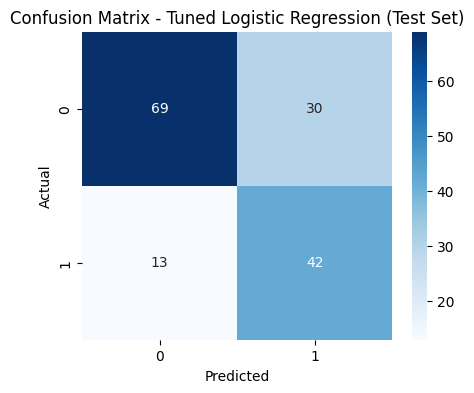

In [35]:
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Tuned Logistic Regression (Test Set)")
plt.show()

## **Support Vector Machine (SVM)**

In [36]:
svm_clf = SVC(probability=True, random_state=42)

In [37]:
param_grid_svm = [
    {
        "kernel": ["linear"],
        "C": [0.001, 0.01, 0.1, 1, 10],
        "class_weight": [None, "balanced"]
    },

    {
        "kernel": ["rbf"],
        "C": [0.01, 0.1, 1, 10],
        "gamma": ["scale", "auto", 0.01, 0.1],
        "class_weight": [None, "balanced"]
    },

    {
        "kernel": ["poly"],
        "C": [0.01, 0.1, 1],
        "gamma": ["scale", "auto"],
        "degree": [2, 3],
        "class_weight": [None, "balanced"]
    }
]

grid_svm = GridSearchCV(estimator=svm_clf,param_grid=param_grid_svm,scoring="f1",cv=5,n_jobs=-1,verbose=2)

grid_svm.fit(X_train_prepared, y_train)

best_svm = grid_svm.best_estimator_
print("Best Params:", grid_svm.best_params_)
print("Best CV F1 Score:", grid_svm.best_score_)

Fitting 5 folds for each of 66 candidates, totalling 330 fits
Best Params: {'C': 10, 'class_weight': 'balanced', 'kernel': 'linear'}
Best CV F1 Score: 0.7037875795479482


In [38]:
y_train_pred_svm = best_svm.predict(X_train_prepared)
print("Train Accuracy:", accuracy_score(y_train, y_train_pred_svm))
print(classification_report(y_train, y_train_pred_svm))

Train Accuracy: 0.7768729641693811
              precision    recall  f1-score   support

           0       0.88      0.77      0.82       401
           1       0.64      0.80      0.71       213

    accuracy                           0.78       614
   macro avg       0.76      0.78      0.77       614
weighted avg       0.80      0.78      0.78       614



In [39]:
y_test_pred_svm = best_svm.predict(X_test_prepared)
print("Test Accuracy:", accuracy_score(y_test, y_test_pred_svm))
print(classification_report(y_test, y_test_pred_svm))

Test Accuracy: 0.7012987012987013
              precision    recall  f1-score   support

           0       0.83      0.68      0.74        99
           1       0.56      0.75      0.64        55

    accuracy                           0.70       154
   macro avg       0.69      0.71      0.69       154
weighted avg       0.73      0.70      0.71       154



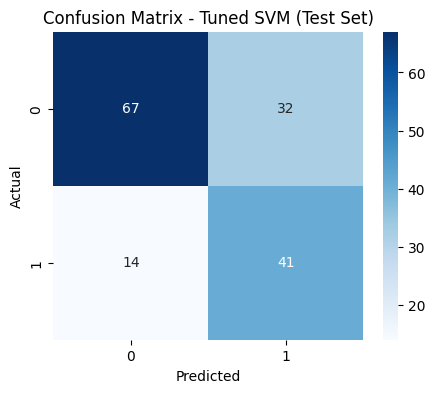

In [40]:
cm_svm = confusion_matrix(y_test, y_test_pred_svm)
plt.figure(figsize=(5,4))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap="Blues", xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Tuned SVM (Test Set)")
plt.show()

## **Random Forest**

In [41]:
rf_clf = RandomForestClassifier(random_state=42)

In [42]:
param_grid_rf = {
    "n_estimators": [100, 200],
    "max_depth": [5, 10],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [5, 10],
    "max_features": ["sqrt", "log2"],
    "class_weight": [None, "balanced"]
}

grid_rf = GridSearchCV(estimator=rf_clf,param_grid=param_grid_rf,scoring="f1",cv=5,n_jobs=-1,verbose=2)

grid_rf.fit(X_train_prepared, y_train)

best_rf = grid_rf.best_estimator_
print("Best Params:", grid_rf.best_params_)
print("Best CV F1 Score:", grid_rf.best_score_)

Fitting 5 folds for each of 64 candidates, totalling 320 fits
Best Params: {'class_weight': 'balanced', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 2, 'n_estimators': 200}
Best CV F1 Score: 0.6946314225019057


In [43]:
y_train_pred_rf = best_rf.predict(X_train_prepared)
print("Train Accuracy:", accuracy_score(y_train, y_train_pred_rf))
print(classification_report(y_train, y_train_pred_rf))

Train Accuracy: 0.8289902280130294
              precision    recall  f1-score   support

           0       0.92      0.81      0.86       401
           1       0.71      0.86      0.78       213

    accuracy                           0.83       614
   macro avg       0.81      0.84      0.82       614
weighted avg       0.84      0.83      0.83       614



In [44]:
y_test_pred_rf = best_rf.predict(X_test_prepared)
print("Test Accuracy:", accuracy_score(y_test, y_test_pred_rf))
print(classification_report(y_test, y_test_pred_rf))

Test Accuracy: 0.7467532467532467
              precision    recall  f1-score   support

           0       0.85      0.74      0.79        99
           1       0.62      0.76      0.68        55

    accuracy                           0.75       154
   macro avg       0.73      0.75      0.74       154
weighted avg       0.77      0.75      0.75       154



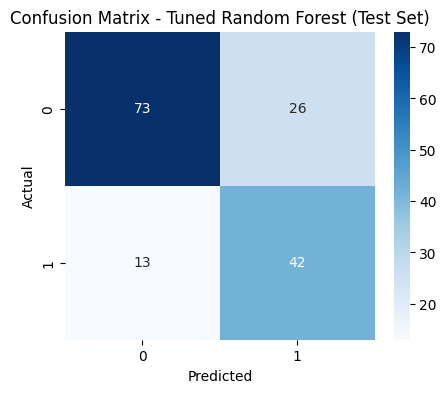

In [45]:
cm_rf = confusion_matrix(y_test, y_test_pred_rf)
plt.figure(figsize=(5,4))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap="Blues", xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Tuned Random Forest (Test Set)")
plt.show()

In [46]:
# Save model
with open("diabetes_model.pkl", "wb") as f:
    pickle.dump({ "model": best_rf, "preprocessor": preprocessor }, f)

print(" Model saved successfully!")


 Model saved successfully!


## **Comparision Between Models**

In [47]:
results = []

# Logistic Regression
results.append({
    "Model": "Logistic Regression",
    "Train Accuracy": round(accuracy_score(y_train, y_train_pred), 3),
    "Train F1": round(f1_score(y_train, y_train_pred), 3),
    "Test Accuracy": round(accuracy_score(y_test, y_test_pred), 3),
    "Test F1": round(f1_score(y_test, y_test_pred), 3)
})

# SVM
results.append({
    "Model": "SVM",
    "Train Accuracy": round(accuracy_score(y_train, y_train_pred_svm), 3),
    "Train F1": round(f1_score(y_train, y_train_pred_svm), 3),
    "Test Accuracy": round(accuracy_score(y_test, y_test_pred_svm), 3),
    "Test F1": round(f1_score(y_test, y_test_pred_svm), 3)
})

# Random Forest
results.append({
    "Model": "Random Forest",
    "Train Accuracy": round(accuracy_score(y_train, y_train_pred_rf), 3),
    "Train F1": round(f1_score(y_train, y_train_pred_rf), 3),
    "Test Accuracy": round(accuracy_score(y_test, y_test_pred_rf), 3),
    "Test F1": round(f1_score(y_test, y_test_pred_rf), 3)
})

# Create comparison table
df_results = pd.DataFrame(results)
print(df_results)

                 Model  Train Accuracy  Train F1  Test Accuracy  Test F1
0  Logistic Regression           0.782     0.716          0.721    0.661
1                  SVM           0.777     0.713          0.701    0.641
2        Random Forest           0.829     0.777          0.747    0.683


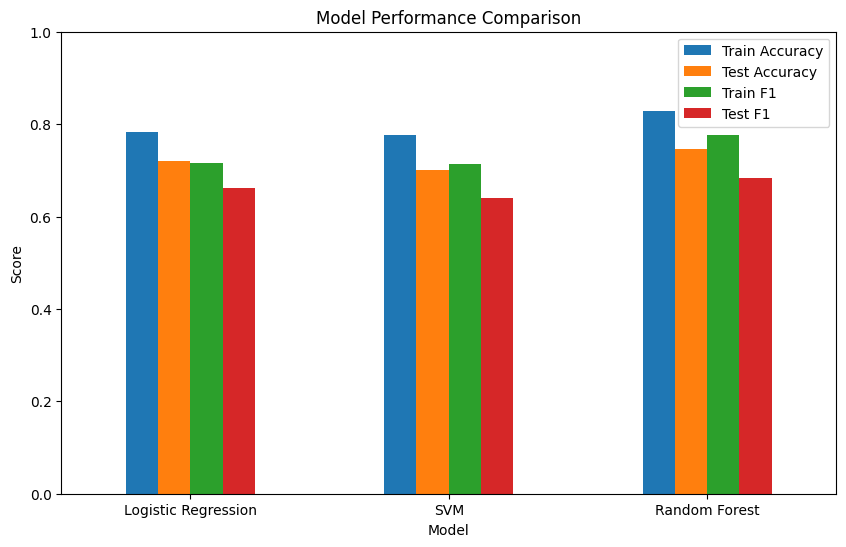

In [48]:
# Bar plot for comparison
df_results.set_index("Model")[["Train Accuracy", "Test Accuracy", "Train F1", "Test F1"]].plot(
    kind="bar", figsize=(10,6), title="Model Performance Comparison", rot=0)
plt.ylabel("Score")
plt.ylim(0, 1)
plt.show()

### Final Results conclusion

The results show that **Random Forest achieved the best performance**, with a test accuracy of **74.7%** and an F1 score of **0.683**, while keeping the train–test gap relatively small (~8%).  
Both **Logistic Regression** and **SVM** performed consistently with lower variance, achieving around **70–72% accuracy** and **0.64–0.66 F1**.  


Thus, Random Forest can be considered the best model for this problem, while Logistic Regression serves as a reliable baseline.

# **Phase 4: Launch Your Prediction Engine!**

In [49]:
# Load model
with open("diabetes_model.pkl", "rb") as f:
    saved_objects = pickle.load(f)

loaded_model = saved_objects["model"]
loaded_preprocessor = saved_objects["preprocessor"]

print(" Model loaded successfully!")

 Model loaded successfully!


In [50]:
def preprocess_patient(patient_dict):
    df = pd.DataFrame([patient_dict])

    #  Cap columns that are not extremely skewed
    cap_columns = ['BloodPressure', 'BMI', 'DiabetesPedigreeFunction']
    for col in cap_columns:
        Q1 = train_data[col].quantile(0.25)
        Q3 = train_data[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        df[col] = np.where(df[col] < lower, lower,
                           np.where(df[col] > upper, upper, df[col]))

    # Log transform skewed columns
    df['Insulin'] = np.log1p(df['Insulin'])

    #  Age groups
    age_bins = [0, 20, 30, 40, 50, 60, 70, 120]
    age_labels = ['<20', '20s','30s','40s','50s','60s','70+']
    age_mapping = {'<20': 0, '20s': 1, '30s': 2, '40s': 3, '50s': 4, '60s': 5, '70+': 6}

    df['AgeGroup'] = pd.cut(df['Age'], bins=age_bins, labels=age_labels, include_lowest=True)
    df['AgeGroup'] = df['AgeGroup'].map(age_mapping).astype(int)

    # Pregnancies per Age ratio
    df['Preg_Age_Ratio'] = df['Pregnancies'] / df['Age']

    # 5. BMI category → one-hot
    def bmi_category(bmi):
        if bmi < 18.5:
            return 'Underweight'
        elif bmi < 25:
            return 'Normal'
        elif bmi < 30:
            return 'Overweight'
        else:
            return 'Obese'

    df['BMI_Category'] = df['BMI'].apply(bmi_category)
    df = df.join(pd.get_dummies(df['BMI_Category'], dtype=int)).drop('BMI_Category', axis=1)

    # Glucose × BMI interaction
    df['Glucose_BMI'] = df['Glucose'] * df['BMI']

    # Ensure all BMI dummies exist
    for col in ['Underweight', 'Normal', 'Overweight', 'Obese']:
        if col not in df.columns:
            df[col] = 0

    # Ensure all train features exist
    train_features = train_data.drop("Outcome", axis=1).columns
    for col in train_features:
        if col not in df.columns:
            df[col] = 0

    #  Force exact same order
    df = df[train_features]

    return df

In [52]:
patient_data = {
    "Pregnancies": 2,
    "Glucose": 120,
    "BloodPressure": 70,
    "SkinThickness": 30,
    "Insulin": 80,
    "BMI": 35,
    "DiabetesPedigreeFunction": 0.5,
    "Age": 30
}

# Preprocess and predict
patient_features = preprocess_patient(patient_data)
X_processed = loaded_preprocessor.transform(patient_features)
pred = loaded_model.predict(X_processed)[0]
prob = loaded_model.predict_proba(X_processed)[0][1]

result = "Diabetic" if pred == 1 else "Non-Diabetic"
print(f"Prediction: {result}\nProbability: {prob:.2%}")

Prediction: Non-Diabetic
Probability: 41.59%
